# Figure 2c-d. Restriction stats and scalings

One of the common approaches to HI-C data analysis is based to analyse the contacts of the restriction fragments(e.g., it is used in *hiclib*, Juicer, HiC-Pro). 
However, in `pairtools` we do not limit our analysis to the restriction sites and provide comprehensive contacts instead. 

We use the notion of convergent point between orientation-dependent scalings [1] that is the distance at which the probabilities of contact in any orientation (+-, ++, -- and -+) are the same. Artifact restriction- and ligation-dependent contacts usually form at very short distances and contribute to peaks of short-range +- interactions (dangling ends and undigested restriction site) or -+ interactions (self-circles). Removing all contacts below this convergent point is sufficient to remove most artifacts. For some chromosome capture protocols it's the only opportunity to remove digestion artifacts (such as Micro-C), because the position of possible cut site is unknown.

In this notebook, we aim to justify the transition from restriction sites annotation and filtration to restriction-free analysis of Hi-C. 
We will take a bunch of datasets from 4DN, try restriction annotation for them, and demonstrate that it's not needed. 

[1] Rao, S. S., Huntley, M. H., Durand, N. C., Stamenova, E. K., Bochkov, I. D., Robinson, J. T., Sanborn, A. L., Machol, I., Omer, A. D., Lander, E. S., & Aiden, E. L. (2014). A 3D map of the human genome at kilobase resolution reveals principles of chromatin looping. Cell, 159(7), 1665–1680. https://doi.org/10.1016/j.cell.2014.11.021

Selected data table (HFF cells, FA+DSG cross-linker preferred) with 4DN portal ID:
```
DpnII: 4DNFIYL4411E file from 4DNESNMAAN97
DpnII+DdeI: 4DNFIOFGGOP6 file from 4DNESN49VY8X
DdeI: 4DNFIEPZKDJE file from 4DNESH5YI3CM
MNase: 4DNFICOEXGPJ from 4DNESWST3UBH (fixation unclear)
HindIII: 4DNFIJAKH2X3 from 4DNES8J78WV2 (fixation unclear)
```


## Data download and pre-processing

In [ ]:
%%bash
# Download human genome:
mkdir -p data/
wget https://hgdownload.cse.ucsc.edu/goldenpath/hg38/bigZips/hg38.fa.gz -P ./data
gzip -d data/hg38.fa.gz

# Create file with chromosome sizes: 
faidx data/hg38.fa -i chromsizes > data/hg38.chromsizes

In [ ]:
%%bash
# restrict the genome:
for renzyme in DpnII DdeI HindIII MboI 
do
    cooler digest ./data/hg38.chromsizes ./data/hg38.fa $renzyme >./data/hg38.$renzyme.restricted.bed
done

In [ ]:
%%bash
# Download selected datasets, requires registration at 4DN,
# Substitute {key:value for 4DN access} with your key:value: {key:value for 4DN access}
cd ./data/
curl -O -L --user RDTEGJ7R:hr3qd3br2rjxsyia https://data.4dnucleome.org/files-processed/4DNFIYL4411E/@@download/4DNFIYL4411E.pairs.gz
# Should be repeated with all test datasets

In [ ]:
%%bash
# Calculate number of pairs in each dataset
gzip -dc data1/4DNFIYL4411E.pairs.gz | grep -v "#" | wc -l

In [ ]:
%%bash 
# Sample the ratio of the file that will produce around several million of pairs (e.g. 11 mln).
# It will speed up the calculations but will be enough to produce averaged statistics:
pairtools sample 0.0084 ./data/4DNFIYL4411E.pairs.gz -o ./data/4DNFIYL4411E.sampled.pairs.gz

In [ ]:
%%bash 
# Restrict all your datasets
for pref in 4DNFIYL4411E 
do
    pairtools restrict ./data/$pref.sampled.pairs.gz -f ./data/hg38.MboI.restricted.bed -o ./data/$pref.sampled.MboI.pairs.gz
    pairtools restrict ./data/$pref.sampled.pairs.gz -f ./data/hg38.HindIII.restricted.bed -o ./data/$pref.sampled.HindIII.pairs.gz
    pairtools restrict ./data/$pref.sampled.pairs.gz -f ./data/hg38.DpnII.restricted.bed -o ./data/$pref.sampled.DpnII.pairs.gz
    pairtools restrict ./data/$pref.sampled.pairs.gz -f ./data/hg38.DdeI.restricted.bed -o ./data/$pref.sampled.DdeI.pairs.gz
done

## Pair analysis

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pandas.plotting import table 

import matplotlib.pyplot as plt
import matplotlib.ticker 
import matplotlib.gridspec
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import bioframe
import pairtools
from pairtools.lib import headerops, fileio

In [2]:
id_4dn = "4DNFIYL4411E"
renzyme = "DpnII"
pairs_file = f'./data/{id_4dn}.sampled.{renzyme}.pairs.gz'

In [16]:
pairs_stream = fileio.auto_open(pairs_file, 'r')
header, pairs_stream = headerops.get_header(pairs_stream)
columns = headerops.get_colnames(header)

In [17]:
df = pd.read_table(pairs_stream, comment="#", header=None, nrows=10_000_000)
df.columns = columns

In [18]:
# Calculate distances to closest restriction fragments to the left and to the right from the 5' cutting position: 
df.loc[:, 'dist_rfrag1_left'] = df.pos1 - df.rfrag_start1
df.loc[:, 'dist_rfrag1_right'] = df.rfrag_end1 - df.pos1

df.loc[:, 'dist_rfrag2_left'] = df.pos2 - df.rfrag_start2
df.loc[:, 'dist_rfrag2_right'] = df.rfrag_end2 - df.pos2

### 1. Plot the distribution of the distances to the restriction sites
Many of the 5'-ends of reads are mapped to the restriction sites: 

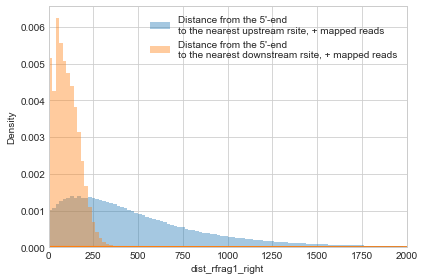

In [6]:
xmin = 0
xmax = 2000
step = 20

sns.distplot(df.query('strand1=="+"').dist_rfrag1_left, bins=np.arange(xmin, xmax, step), label='Distance from the 5\'-end\nto the nearest upstream rsite, + mapped reads')
sns.distplot(df.query('strand1=="+"').dist_rfrag1_right, bins=np.arange(xmin, xmax, step), label='Distance from the 5\'-end\nto the nearest downstream rsite, + mapped reads')

plt.xlim(xmin, xmax)
plt.legend()
plt.tight_layout()

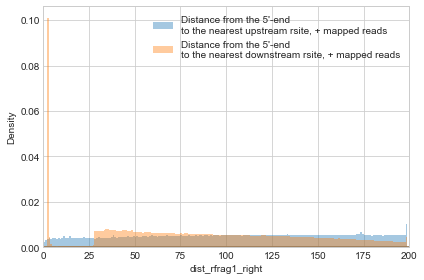

In [7]:
# Zoom in a little:
xmin = 0
xmax = 200
step = 1

sns.distplot(df.query('strand1=="+"').dist_rfrag1_left, bins=np.arange(xmin, xmax, step), label='Distance from the 5\'-end\nto the nearest upstream rsite, + mapped reads')
sns.distplot(df.query('strand1=="+"').dist_rfrag1_right, bins=np.arange(xmin, xmax, step), label='Distance from the 5\'-end\nto the nearest downstream rsite, + mapped reads')

plt.xlim(xmin, xmax)
plt.legend()
plt.tight_layout()

### 2. Scalings for pairs at different ditances from restriction sites

```
(Arguement for Restriction Annotation I)

Traditional Hi-C uses a restriction enzyme that cuts certain sequences in the genome and demarcates the ends of DNA fragments prior to ligation. The pairs located too far from the nearest restriction site are usually treated as indicative of failed protocol. 
```

Let's plot the scalings for pairs originating from different distances from the restriction sites and check whether they differ much. 

In [8]:
hg38_chromsizes = bioframe.fetch_chromsizes('hg38', as_bed=True)
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, dict(hg38_cens.set_index('chrom').mid), cols_chroms=('chrom', 'start', 'end') )

# To fix pandas bug in some versions: 
hg38_arms['start'] = hg38_arms['start'].astype(int)
hg38_arms['end'] = hg38_arms['end'].astype(int)

In [9]:
import pairtools.lib.scaling as scaling
def plot(cis_scalings, trans_levels, 
         n_total=None, xlim=(1e1,1e7), 
         label='', orientations=['+-', '-+', '++', '--'], 
         norm=False, ax=None, colors=None # length is [orientations + trans]
        ):
    
    if ax is None: 
        fig, ax = plt.subplots(1,1)
        
    if colors is None: 
        cmap = plt.get_cmap('tab10', len(orientations))
        colors = [cmap(i) for i in np.linspace(0, 1, len(orientations))] + ['black']
        
    strand_gb = cis_scalings.groupby(['strand1', 'strand2'])
    for i, strands in enumerate(orientations):
        if strands=="all":
            sc_strand = cis_scalings
        else:
            sc_strand = strand_gb.get_group(tuple(strands))
        sc_agg = (sc_strand
            .groupby(['min_dist','max_dist'])
            .agg({'n_pairs':'sum', 'n_bp2':'sum'})
            .reset_index())

        dist_bin_mids = np.sqrt(sc_agg.min_dist * sc_agg.max_dist)
        pair_frequencies = sc_agg.n_pairs / sc_agg.n_bp2
        if n_total is not None:
            pair_frequencies = pair_frequencies/n_total #cis_scalings.n_pairs.sum()
        mask = pair_frequencies>0
        label_long = f'{strands[0]}{strands[1]} {label}'

        if norm:
            pair_frequencies = scaling.unity_norm_scaling(
                np.concatenate([dist_bin_mids, [np.nan]]), 
                pair_frequencies, 
                norm_range=[1e4, 1e7]
            )
        if np.sum(mask)>0:
            ax.loglog(
                dist_bin_mids[mask],
                pair_frequencies[mask],
                label=label_long,
                lw=2,
                color=colors[i]
            )

    ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0,numticks=20))
    ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0,numticks=20))
    ax.set_aspect(1.0)
    ax.set_xlim(xlim)

    if not colors[-1] is None: 
        avg_trans = (
            trans_levels.n_pairs.astype('float64').sum() 
            / trans_levels.np_bp2.astype('float64').sum()
        )
        if n_total is not None:
            avg_trans = avg_trans/n_total

        ax.axhline(avg_trans, ls='--', c=colors[-1], label='avg trans {label}')

    ax.grid(lw=0.5,color='gray')
    ax.legend(loc="upper right")
    ax.set_ylabel('contact frequency, \nHi-C molecule per bp pair normalized by total')
    ax.set_xlabel('distance, bp')


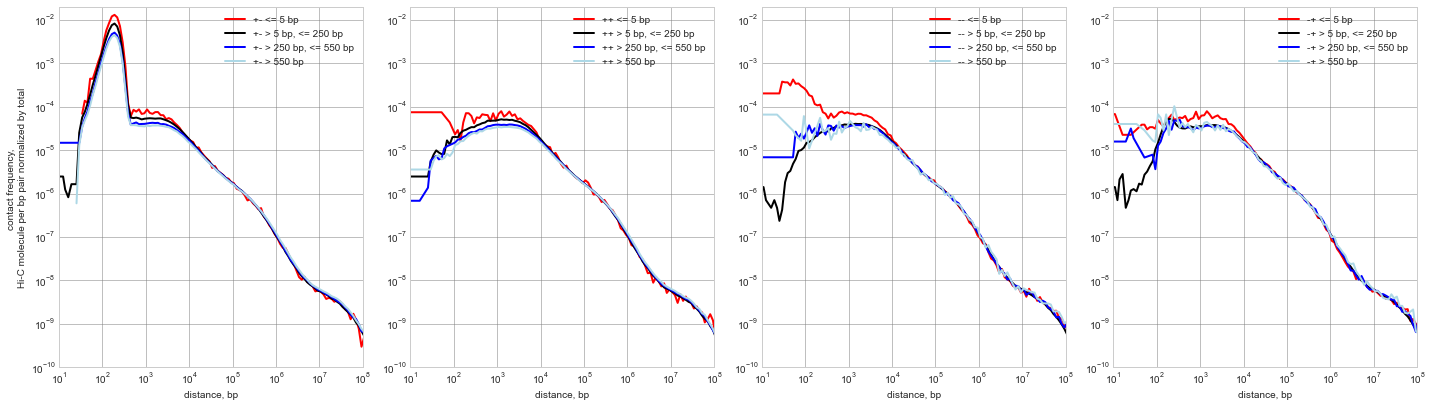

In [11]:
fig, axes = plt.subplots(1, 4, figsize=[20, 10])

colors = ['red', 'black', 'blue', 'lightblue']
pair_types = [
    "<= 5 bp",
    "> 5 bp, <= 250 bp",
    "> 250 bp, <= 550 bp",
    "> 550 bp",
]
conditions = [
    "(dist_rfrag1_left<=5)",
    "(dist_rfrag1_left>5 and dist_rfrag1_left<=250)",
    "(dist_rfrag1_left>250 and dist_rfrag1_left<=550)",
    "(dist_rfrag1_left>550)",
]

for i, orientation in enumerate( ["+-", "++", "--", "-+"] ):
    for color, pair_type, condition in zip(colors, pair_types, conditions):
        # print(orientation, pair_type)
        df_subset = df.query(condition)
        try:
            cis_scalings_subset, trans_levels_subset = scaling.compute_scaling(
                    df_subset,
                    regions=hg38_arms,
                    chromsizes=hg38_arms,
                    dist_range=(10, 1e9), 
                    n_dist_bins=128,
                    chunksize=int(1e7),
                )
            plot(cis_scalings_subset, trans_levels_subset, 
                 n_total=None, 
                 xlim=(10,1e8), 
                 orientations=[orientation], 
                 norm=True, 
                 ax=axes[i], 
                 label=pair_type, 
                 colors=[color, None])
        except Exception as e:
            pass

    axes[i].set_ylim(1e-10, 2e-2)
    if i!=0:
        axes[i].set_ylabel("")
    
fig.tight_layout()
fig.savefig(f"./Figure2c_{id_4dn}_{renzyme}.pdf")

### 3. Distance cutoff vs Strict filtering of dangling ends and self-circles

```
(Argument for Restriction Annotation II)

After annotation, the contact pairs that are located at the neighboring restriction fragments in the genome can be categorized by orientation as various types of Hi-C by-products: self-circles (inwards facing orientation), dangling ends (outwards facing orientation) or error/mirror reads (same orientation). The percentages of these types of pairs guided the researcher in the optimization of the protocol. These Hi-C by-products can be filtered out before the analysis of Hi-C maps.
```

Restriction-free analysis proposes convergent point of orientation-depended scalings to measure the Hi-C distances affected by artifacts.
Removal of all contacts below this convergent point will remove nearly all artifacts detected by restriction annotation.

In [30]:
df.loc[:, "type_rfrag"] = "Regular pair"

# Typical mask to remove pairs originating from the same or neighboring restrictoin fragments, as they might be self-circles, dangling ends or undigested DNA:
mask_neighboring_rfrags = (np.abs(df.rfrag1-df.rfrag2)<=1)

mask_DE = (df.strand1=="+") & (df.strand2=="-") & mask_neighboring_rfrags
df.loc[mask_DE, "type_rfrag"] = "DanglingEnd"

mask_SS = (df.strand1=="-") & (df.strand2=="+") & mask_neighboring_rfrags
df.loc[mask_SS, "type_rfrag"] = "SelfCircle"

mask_Err = (df.strand1==df.strand2) & mask_neighboring_rfrags
df.loc[mask_Err, "type_rfrag"] = "Mirror" # See the definition and description here: https://www.researchgate.net/publication/312960787_Mirror_reads_in_Hi-C_data 

In [31]:
df.sort_values("type_rfrag").groupby("type_rfrag").count()['readID']

type_rfrag
DanglingEnd     1074288
Mirror            44775
Regular pair    8834678
SelfCircle        46259
Name: readID, dtype: int64

In [20]:
# Function to create convergent point, which will calculate the discrepancy between different orientations,
# and determine the rightmost point where the discrepancy is larger than tolerance * mean(scalings in different orientations): 
import itertools
def detect_convergence_point(cis_scalings, tolerance=1e-2):
    
    orientations = ['+-', '-+', '++', '--']
    strand_gb = cis_scalings.groupby(['strand1', 'strand2'])
    scalings = {}
    for strands in orientations:
        sc_strand = strand_gb.get_group(tuple(strands))
        sc_agg = (sc_strand
            .groupby(['min_dist','max_dist'])
            .agg({'n_pairs':'sum', 'n_bp2':'sum'})
            .reset_index())

        dist_bin_mids = np.sqrt(sc_agg.min_dist * sc_agg.max_dist)
        pair_frequencies = sc_agg.n_pairs / sc_agg.n_bp2
        pair_frequencies = pair_frequencies/cis_scalings.n_pairs.sum()
        
        scalings[f'{strands[0]}{strands[1]}'] = pair_frequencies.copy()
        
    mean_values = np.nanmean( np.array([scalings[x] for x in orientations]), axis=0 )
    th = mean_values * tolerance
    
    combinations = list(itertools.combinations(['-+', '--', '++', '+-'], 2))

    v = np.ones(len(scalings['+-']), dtype=np.bool)
    for orient1, orient2 in combinations:
        # We want all the scalings for all the orientations be less than threshold:
        discrepancy = np.abs(scalings[orient1]-scalings[orient2]).values
        is_smaller = np.less(discrepancy, th)
        v &= is_smaller
    
    convergent_points = np.where(v)[0]
    
    return dist_bin_mids[convergent_points].values, convergent_points, v, mean_values # conv_points_bp, convergent_points, is_convergent_track, mean_values


In [24]:
cis_scalings, trans_levels = scaling.compute_scaling(
                df,
                regions=hg38_arms,
                chromsizes=hg38_arms,
                dist_range=(10, 1e9), 
                n_dist_bins=128,
                chunksize=int(1e7)
            )

In [25]:
conv_points_bp, convergent_points, is_convergent_track, mean_values = detect_convergence_point(cis_scalings, tolerance=0.1)
conv_point = conv_points_bp[0]

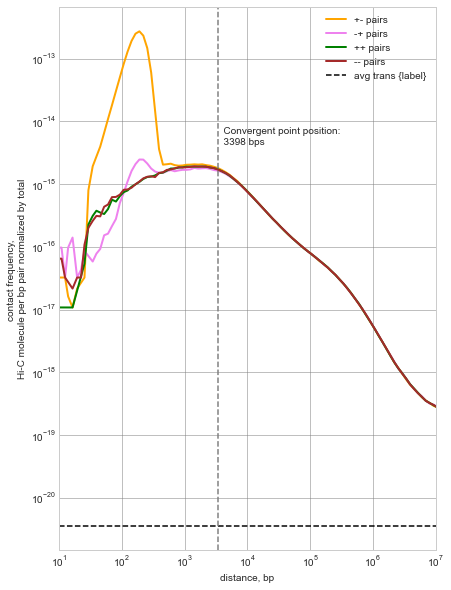

In [26]:
# Full scaling
n = len(df)

fig, ax = plt.subplots(1, 1, figsize=[10,10])
plot(cis_scalings, trans_levels, n, label="pairs", ax=ax, colors=["orange", "violet", "green", "brown", "black"])

# The point where the scalings by distance become balanced:
plt.axvline(conv_point, ls='--', c='gray', label='Balancing point')
plt.text(conv_point, np.nanmean(mean_values), f"  Convergent point position:\n  {conv_point:.0f} bps")

fig.savefig(f"./Figure2d_{id_4dn}_{renzyme}.pdf")

Convergent point with tolerance 0.5 for this dataset is around 3.4 Kb.
It means that distances > 3.4 Kb should be used for Hi-C analysis. 

This distance is much larger than the average fragment length for DpnII enzyme (around 200 bps). 

In [27]:
df.loc[:, "type_bydist"] = "Regular pair"

mask_ondiagonal = (np.abs(df.pos2-df.pos1)<=conv_point)

mask_DE = (df.strand1=="+") & (df.strand2=="-") & mask_ondiagonal
df.loc[mask_DE, "type_bydist"] = "DanglingEnd"

mask_SS = (df.strand1=="-") & (df.strand2=="+") & mask_ondiagonal
df.loc[mask_SS, "type_bydist"] = "SelfCircle"

mask_Err = (df.strand1==df.strand2) & mask_ondiagonal
df.loc[mask_Err, "type_bydist"] = "Mirror"

In [28]:
df.sort_values("type_bydist").groupby("type_bydist").count()['readID']

type_bydist
DanglingEnd     1372204
Mirror           365611
Regular pair    8085839
SelfCircle       176346
Name: readID, dtype: int64

In [32]:
df_toplot = df.sort_values(["type_rfrag", "type_bydist"])\
    .groupby(["type_rfrag", "type_bydist"])\
    .count()[['readID']]\
    .reset_index()\
    .pivot(columns="type_bydist", index="type_rfrag")\
    .fillna(0).astype(int)

In [33]:
df_toplot

readID                                
type_bydist  DanglingEnd  Mirror Regular pair SelfCircle
type_rfrag                                              
DanglingEnd      1074283       0            5          0
Mirror                 0   44728           47          0
Regular pair      297921  320883      8085678     130196
SelfCircle             0       0          109      46150

In this table, False Positives are in 3rd row (except the diagonal; removed by distance filter but will not be picked by restriction-based filtration), False Negatives are in 3rd column (except the diagonal; not removed by distance filter but should be removed by restriction-based diltration).

Filtering by distance is, thus, nearly as effective as filtering by restriction fragment, but removes additional pairs that can be potential undercut by restriction enzyme.

Removing all contacts closer than 3.4 Kb for this dataset will remove Hi-C artifacts.

In [34]:
# Save the table as figure
fig, ax = plt.subplots(1, 1, figsize=[20, 3]) 
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

table(ax, df_toplot) 
plt.savefig(f"./Figure2e_{id_4dn}_{renzyme}.pdf")
plt.close()

## Calculate for other enzymes
Quick reminder of what are the datasets:
```
DpnII: 4DNFIYL4411E file from 4DNESNMAAN97
DpnII+DdeI: 4DNFIOFGGOP6 file from 4DNESN49VY8X
DdeI: 4DNFIEPZKDJE file from 4DNESH5YI3CM
MNase: 4DNFICOEXGPJ from 4DNESWST3UBH (fixation unclear)
HindIII: 4DNFIJAKH2X3 from 4DNES8J78WV2 (fixation unclear)
```

readID                                
type_bydist  DanglingEnd  Mirror Regular pair SelfCircle
type_rfrag                                              
DanglingEnd      1074283       0            5          0
Mirror                 0   44728           47          0
Regular pair      297921  320883      8085678     130196
SelfCircle             0       0          109      46150

readID                                
type_bydist  DanglingEnd  Mirror Regular pair SelfCircle
type_rfrag                                              
DanglingEnd      1593739       0           11          0
Mirror                 0  162753           31          0
Regular pair      711250  769391      6361878     316431
SelfCircle             0       0           43      84473

readID                                
type_bydist  DanglingEnd  Mirror Regular pair SelfCircle
type_rfrag                                              
DanglingEnd      1418036       0           63          0
Mirror                 0  104589           82          0
Regular pair      886953  827555      6361772     360348
SelfCircle             0       0           46      40556

readID                                
type_bydist  DanglingEnd  Mirror Regular pair SelfCircle
type_rfrag                                              
DanglingEnd       953901       0            2          0
Mirror                 0   25648            6          0
Regular pair      801644  422396      7587116     182677
SelfCircle             0       0            8      26602

readID                                 
type_bydist  DanglingEnd   Mirror Regular pair SelfCircle
type_rfrag                                               
DanglingEnd      1054701        0           56          0
Mirror                 0  1615204          106          0
Regular pair     1063612  1609400      3231860     653462
SelfCircle             0        0           57     771542

readID                               
type_bydist  DanglingEnd Mirror Regular pair SelfCircle
type_rfrag                                             
DanglingEnd      1802070      0          418          0
Mirror                 0  49316        21345          0
Regular pair       61968  31739      7968584       4657
SelfCircle             0      0        26665      33238

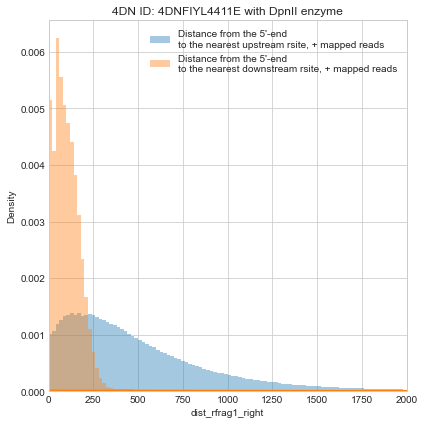

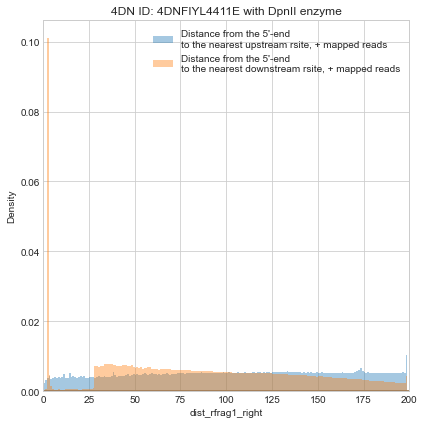

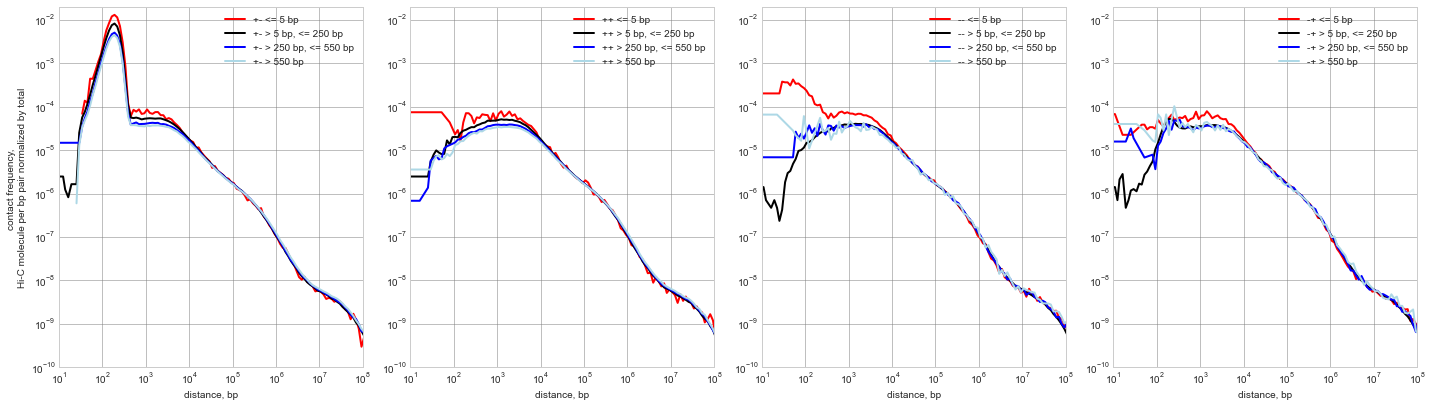

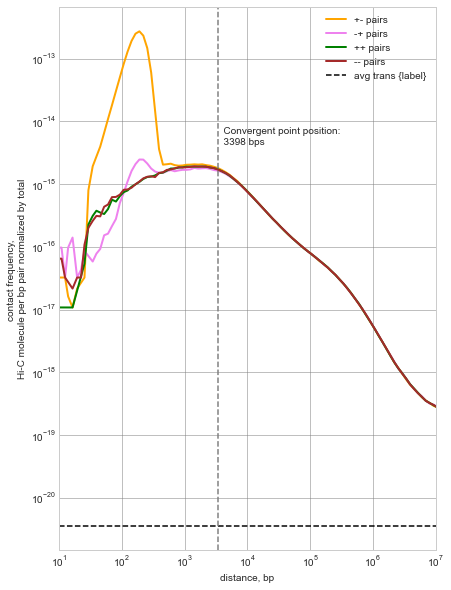

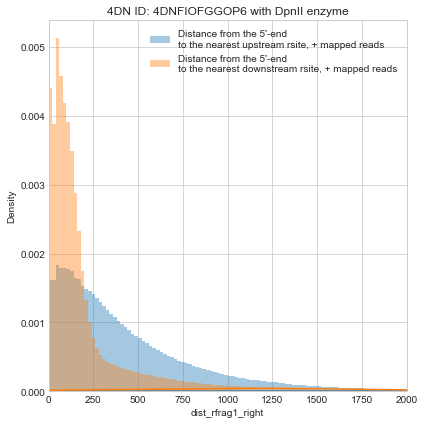

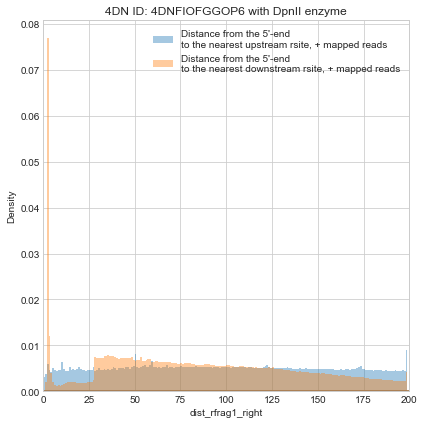

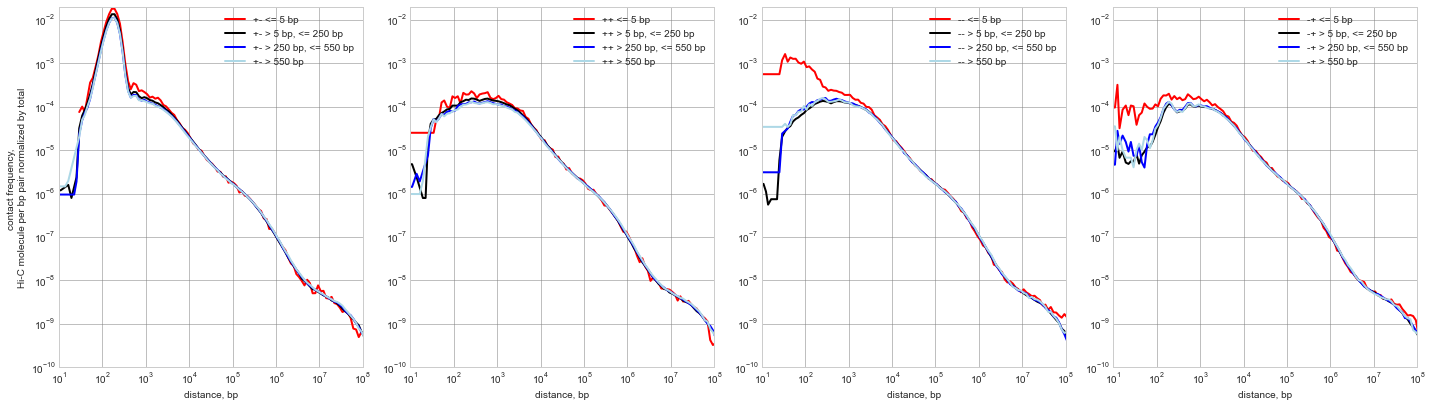

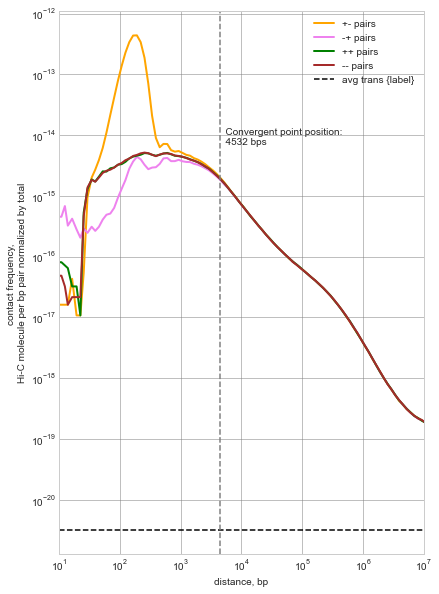

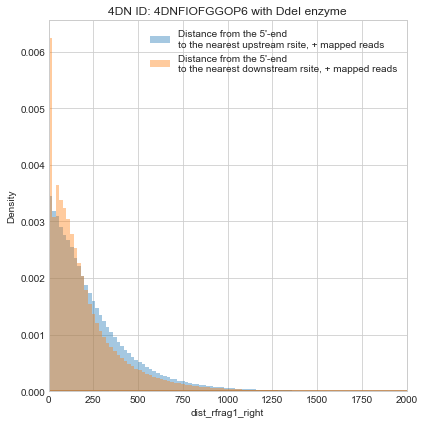

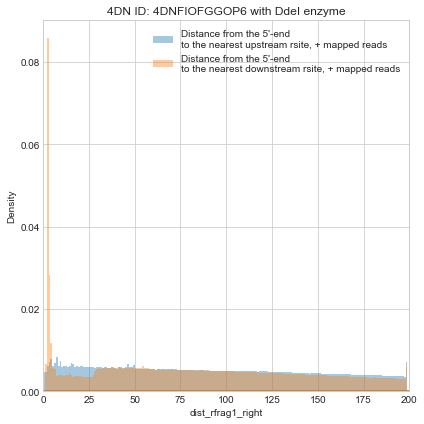

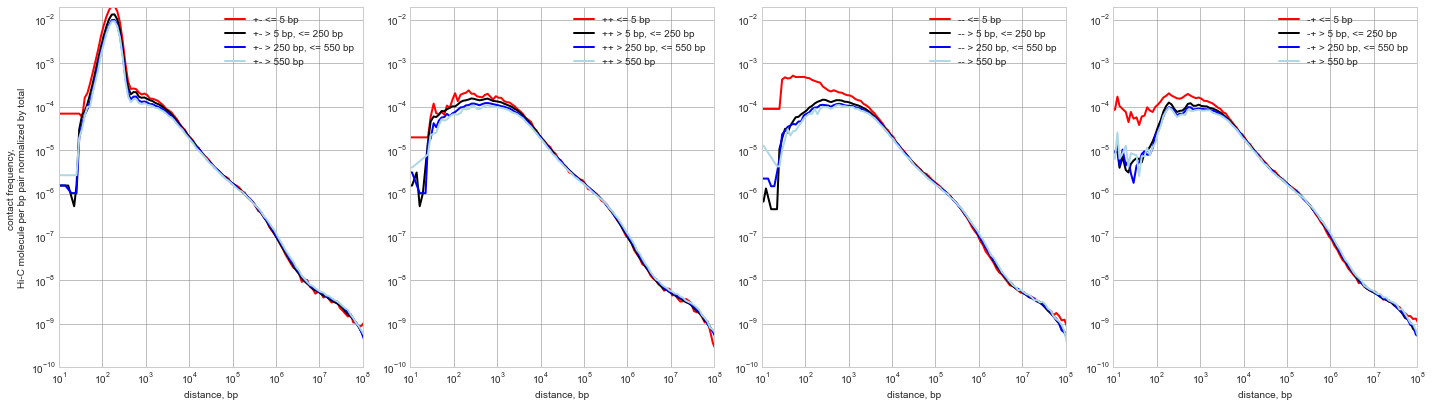

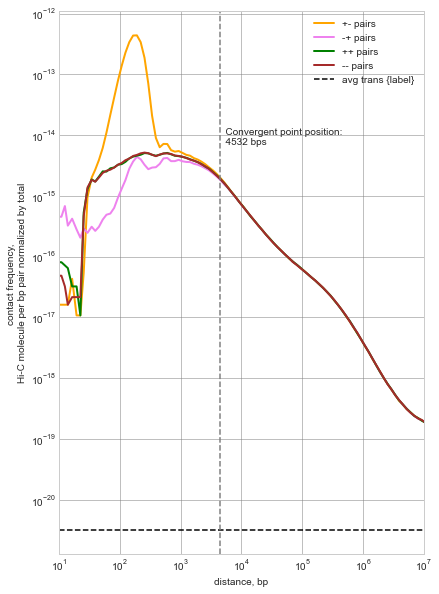

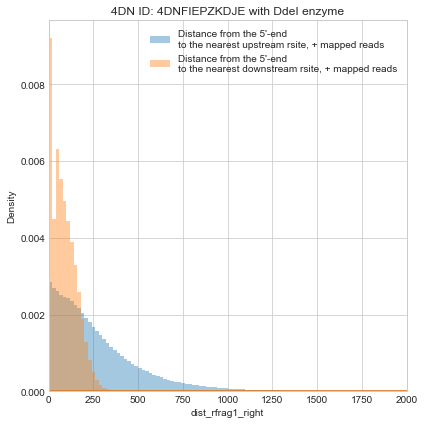

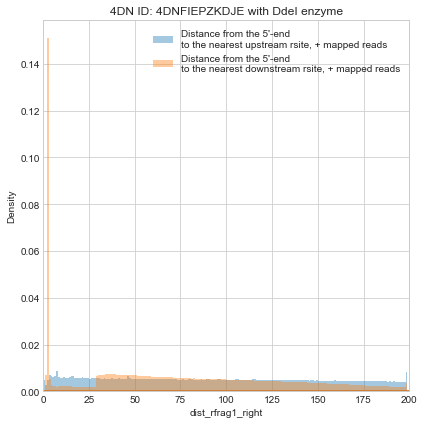

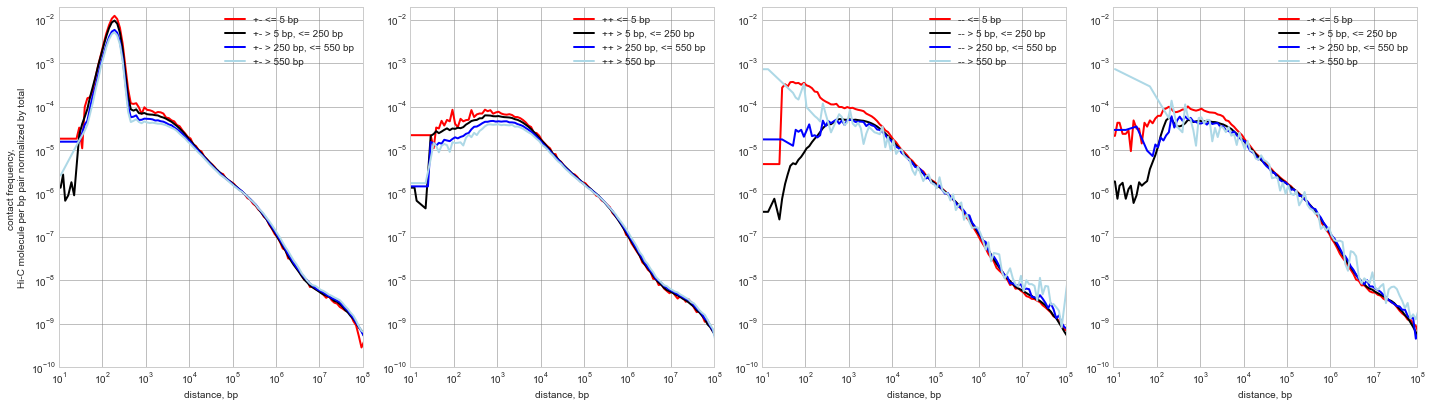

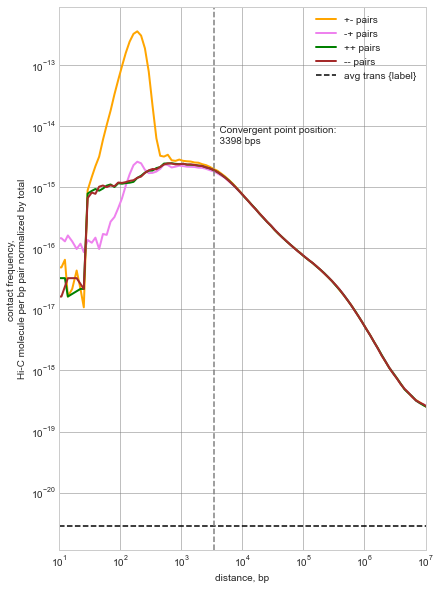

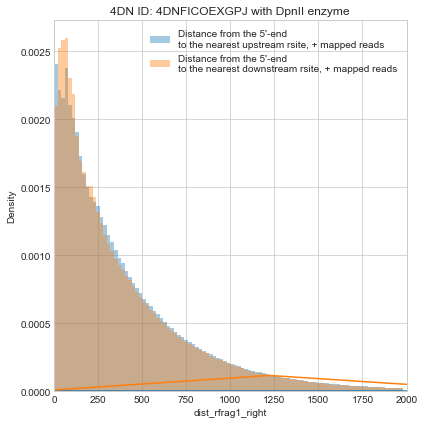

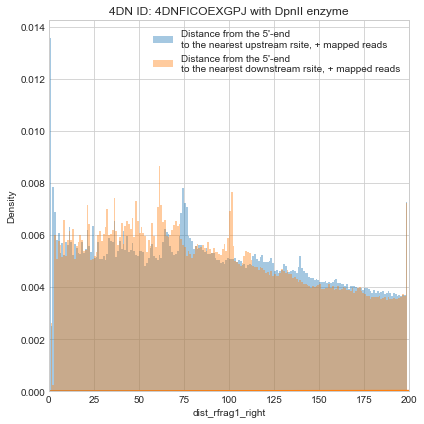

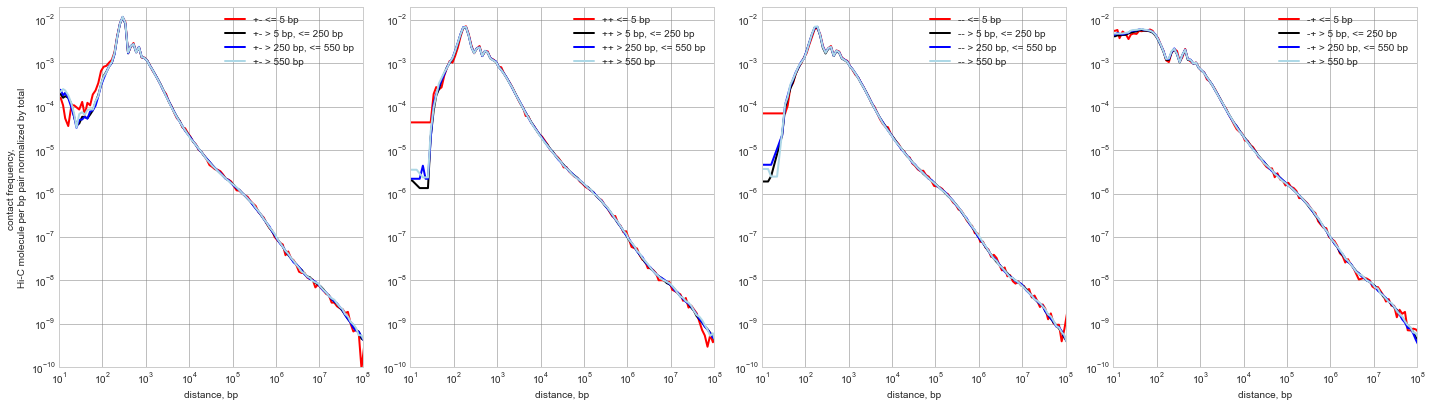

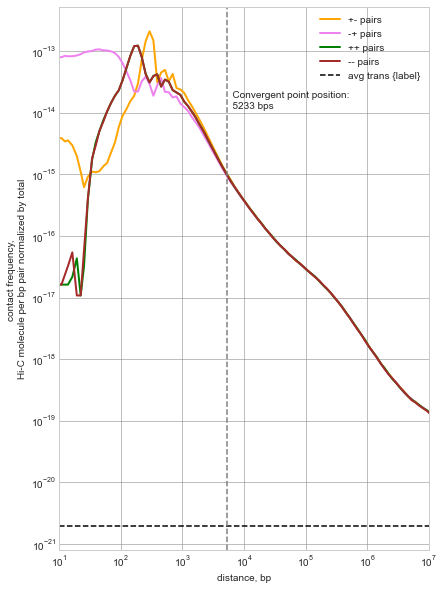

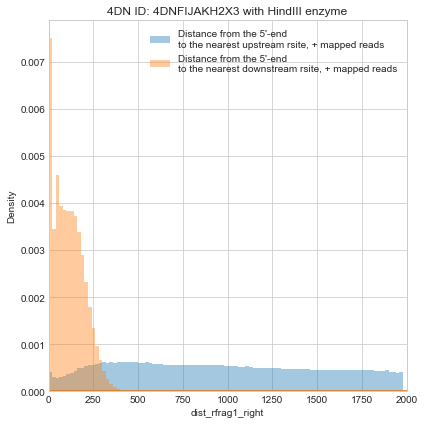

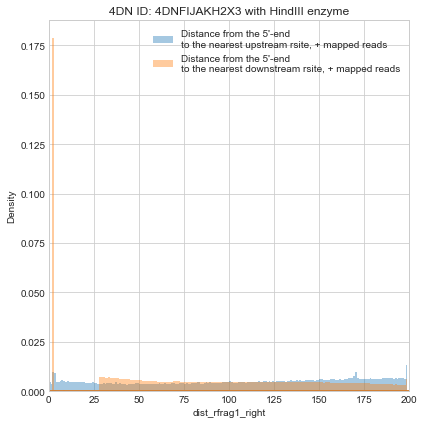

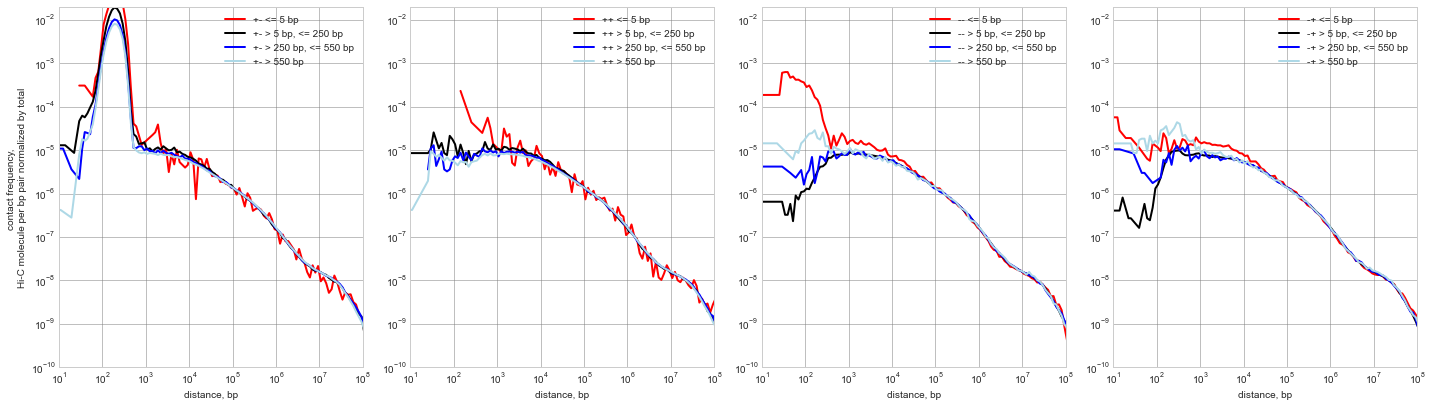

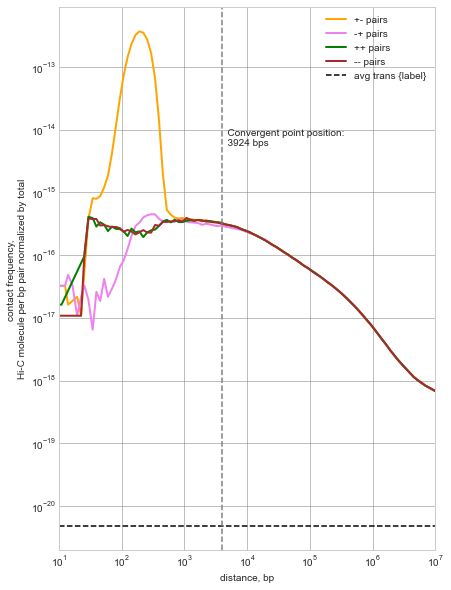

In [35]:
for id_4dn, renzyme in zip(
    ["4DNFIYL4411E", "4DNFIOFGGOP6", "4DNFIOFGGOP6", "4DNFIEPZKDJE", "4DNFICOEXGPJ", "4DNFIJAKH2X3"],
    ["DpnII", "DpnII", "DdeI", "DdeI", "DpnII", "HindIII"]
):

    pairs_file = f'./data/{id_4dn}.sampled.{renzyme}.pairs.gz'

    # Load the dataset:
    pairs_stream = fileio.auto_open(pairs_file, 'r')
    header, pairs_stream = headerops.get_header(pairs_stream)
    columns = headerops.get_colnames(header)

    df = pd.read_table(pairs_stream, comment="#", header=None, nrows=10_000_000)
    df.columns = columns

    ###########
    # Calculate distances to closest restriction fragments to the left and to the right from the 5' cutting position: 
    df.loc[:, 'dist_rfrag1_left'] = df.pos1 - df.rfrag_start1
    df.loc[:, 'dist_rfrag1_right'] = df.rfrag_end1 - df.pos1

    df.loc[:, 'dist_rfrag2_left'] = df.pos2 - df.rfrag_start2
    df.loc[:, 'dist_rfrag2_right'] = df.rfrag_end2 - df.pos2


    for xmin, xmax, step in zip([0, 0], [2000, 200], [20, 1]):
        plt.figure(figsize=[6, 6])
        sns.distplot(df.query('strand1=="+"').dist_rfrag1_left, bins=np.arange(xmin, xmax, step), label='Distance from the 5\'-end\nto the nearest upstream rsite, + mapped reads')
        sns.distplot(df.query('strand1=="+"').dist_rfrag1_right, bins=np.arange(xmin, xmax, step), label='Distance from the 5\'-end\nto the nearest downstream rsite, + mapped reads')

        plt.xlim(xmin, xmax)
        plt.legend()
        plt.title(f"4DN ID: {id_4dn} with {renzyme} enzyme")
        plt.tight_layout()

    ###########
    # Plot the scalings for different distances to restriction enzyme: 
    fig, axes = plt.subplots(1, 4, figsize=[20, 10])

    colors = ['red', 'black', 'blue', 'lightblue']
    pair_types = [
        "<= 5 bp",
        "> 5 bp, <= 250 bp",
        "> 250 bp, <= 550 bp",
        "> 550 bp",
    ]
    conditions = [
        "(dist_rfrag1_left<=5)",
        "(dist_rfrag1_left>5 and dist_rfrag1_left<=250)",
        "(dist_rfrag1_left>250 and dist_rfrag1_left<=550)",
        "(dist_rfrag1_left>550)",
    ]

    for i, orientation in enumerate( ["+-", "++", "--", "-+"] ):
        for color, pair_type, condition in zip(colors, pair_types, conditions):
            df_subset = df.query(condition)
            try:
                cis_scalings_subset, trans_levels_subset = scaling.compute_scaling(
                        df_subset,
                        regions=hg38_arms,
                        chromsizes=hg38_arms,
                        dist_range=(10, 1e9), 
                        n_dist_bins=128,
                        chunksize=int(1e7),
                    )
                plot(cis_scalings_subset, trans_levels_subset, 
                     n_total=None, 
                     xlim=(10,1e8), 
                     orientations=[orientation], 
                     norm=True, 
                     ax=axes[i], 
                     label=pair_type, 
                     colors=[color, None])
            except Exception as e:
                pass

        axes[i].set_ylim(1e-10, 2e-2)
        if i!=0:
            axes[i].set_ylabel("")

    fig.tight_layout()
    fig.savefig(f"./Figure2c_{id_4dn}_{renzyme}.pdf")

    ########
    # Restriction annotation: 
    df.loc[:, "type_rfrag"] = "Regular pair"

    # Typical mask to remove pairs originating from the same or neighboring restrictoin fragments, as they might be self-circles, dangling ends or undigested DNA:
    mask_neighboring_rfrags = (np.abs(df.rfrag1-df.rfrag2)<=1)

    mask_DE = (df.strand1=="+") & (df.strand2=="-") & mask_neighboring_rfrags
    df.loc[mask_DE, "type_rfrag"] = "DanglingEnd"

    mask_SS = (df.strand1=="-") & (df.strand2=="+") & mask_neighboring_rfrags
    df.loc[mask_SS, "type_rfrag"] = "SelfCircle"

    mask_Err = (df.strand1==df.strand2) & mask_neighboring_rfrags
    df.loc[mask_Err, "type_rfrag"] = "Mirror" # See the definition and description here: https://www.researchgate.net/publication/312960787_Mirror_reads_in_Hi-C_data 

    #########
    # Detect convergent point:
    cis_scalings, trans_levels = scaling.compute_scaling(
                    df,
                    regions=hg38_arms,
                    chromsizes=hg38_arms,
                    dist_range=(10, 1e9), 
                    n_dist_bins=128,
                    chunksize=int(1e7)
                )

    conv_points_bp, convergent_points, is_convergent_track, mean_values = detect_convergence_point(cis_scalings, tolerance=0.1)
    conv_point = conv_points_bp[0]

    #########
    # Plot the convergent point wiht full scaling
    n = len(df)

    fig, ax = plt.subplots(1, 1, figsize=[10,10])
    plot(cis_scalings, trans_levels, n, label="pairs", ax=ax, colors=["orange", "violet", "green", "brown", "black"])

    # The point where the scalings by distance become balanced:
    plt.axvline(conv_point, ls='--', c='gray', label='Balancing point')
    plt.text(conv_point, np.nanmean(mean_values), f"  Convergent point position:\n  {conv_point:.0f} bps")

    fig.savefig(f"./Figure2d_{id_4dn}_{renzyme}.pdf")

    #########
    # Convergent-point annotation
    df.loc[:, "type_bydist"] = "Regular pair"

    mask_ondiagonal = (np.abs(df.pos2-df.pos1)<=conv_point)

    mask_DE = (df.strand1=="+") & (df.strand2=="-") & mask_ondiagonal
    df.loc[mask_DE, "type_bydist"] = "DanglingEnd"

    mask_SS = (df.strand1=="-") & (df.strand2=="+") & mask_ondiagonal
    df.loc[mask_SS, "type_bydist"] = "SelfCircle"

    mask_Err = (df.strand1==df.strand2) & mask_ondiagonal
    df.loc[mask_Err, "type_bydist"] = "Mirror"

    #########
    # Plot final table

    df_toplot = df.sort_values(["type_rfrag", "type_bydist"])\
        .groupby(["type_rfrag", "type_bydist"])\
        .count()[['readID']]\
        .reset_index()\
        .pivot(columns="type_bydist", index="type_rfrag")\
        .fillna(0).astype(int)

    ######### 
    # Display 
    display(df_toplot)
    
    ########
    # Save table as pdf (not very nice)
    fig, ax = plt.subplots(1, 1, figsize=[20, 3]) 
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    table(ax, df_toplot) 
    plt.savefig(f"./Figure2e_{id_4dn}_{renzyme}.pdf")
    plt.close()